In [6]:
import time
import sys
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Read data
source: https://archive.ics.uci.edu/ml/datasets/census+income

In [10]:
import csv
import pandas as pd
from urllib.request import urlopen

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
response = urlopen(url)
print(response.read())
cr = csv.reader(response)

In [8]:
dircr


In [5]:
col = ['age','workclass','fnlwgt','education','edu_code','marital_status','occupation',
       'relationship','race','gender','capital_gain','capital_loss','hours_per_week',
       'country','income']

adult_df = pd.read_csv("umass_adult.data", names=col)
print(adult_df.shape)

(32561, 15)


## Create numerical label: income_level

In [4]:
adult_df["income"] = adult_df.income.str.strip()
cond = (adult_df.income==">50K")
adult_df["income_level"] = 0
adult_df.loc[cond, "income_level"] = 1

print(adult_df.groupby(["income_level","income"]).size()/len(adult_df))

income_level  income
0             <=50K     0.75919
1             >50K      0.24081
dtype: float64


# Data Exploration & Visualization

In [239]:
# check missing values
print(adult_df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
edu_code          0
marital_status    0
occupation        0
relationship      0
race              0
gender            0
capital_gain      0
capital_loss      0
hours_per_week    0
country           0
income            0
income_level      0
dtype: int64


In [240]:
# print data types
print(adult_df.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
edu_code           int64
marital_status    object
occupation        object
relationship      object
race              object
gender            object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
country           object
income            object
income_level       int64
dtype: object


#num_feats = train_df.dtypes[train_df.dtypes != "object"].index
num_feats = ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week', 'income_level']
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(adult_df[num_feats].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Age

In [316]:
print(adult_df.age.describe())
print()
adult_df.groupby(["income_level"], as_index=False)["age"].mean()

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64



,income_level,age
0,0,36.783738
1,1,44.249841


/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


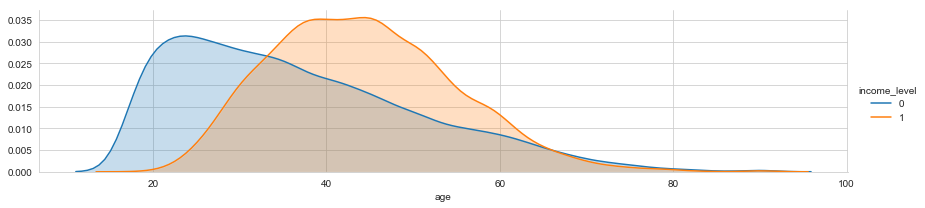

In [313]:
sns.FacetGrid(adult_df, hue="income_level", aspect=4)\
   .map(sns.kdeplot, 'age', shade= True)\
   .add_legend()

## workclass: categorical

In [6]:
adult_df["workclass"] = adult_df.workclass.str.strip()
work_cnt = adult_df.workclass.value_counts()
print(work_cnt)

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

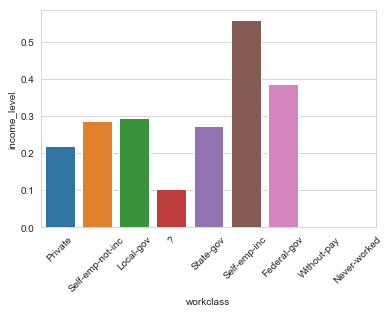

In [7]:
work_perc = adult_df.groupby(["workclass"], as_index=False)["income_level"].mean()
sns.barplot(x="workclass", y="income_level", data=work_perc, order=list(work_cnt.index))  
plt.xticks(rotation=45)

## fnlwgt

In [317]:
print(adult_df.fnlwgt.describe())
print()
adult_df.groupby(["income_level"], as_index=False)["fnlwgt"].mean()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64



,income_level,fnlwgt
0,0,190340.86517
1,1,188005.00000


## education & edu_code: categorical

In [291]:
adult_df["education"] = adult_df.education.str.strip()
print(adult_df.groupby(["education","edu_code"]).size().sort_values(ascending=False))

education     edu_code
HS-grad       9           10501
Some-college  10           7291
Bachelors     13           5355
Masters       14           1723
Assoc-voc     11           1382
11th          7            1175
Assoc-acdm    12           1067
10th          6             933
7th-8th       4             646
Prof-school   15            576
9th           5             514
12th          8             433
Doctorate     16            413
5th-6th       3             333
1st-4th       2             168
Preschool     1              51
dtype: int64


In [ ]:
marital_perc = adult_df.groupby(["marital_status"], as_index=False)["income_level"].mean()
sns.barplot(x="marital_status", y="income_level", data=marital_perc, order=list(marital_cnt.index))  

## maritial_status: categorical

In [288]:
adult_df["marital_status"] = adult_df.marital_status.str.strip()
marital_cnt = adult_df.marital_status.value_counts()
print(marital_cnt)

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

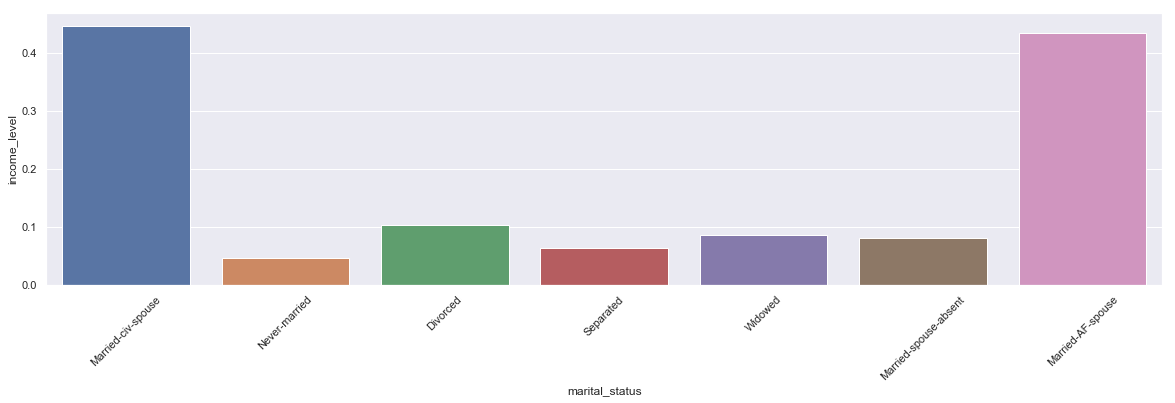

In [338]:
marital_perc = adult_df.groupby(["marital_status"], as_index=False)["income_level"].mean()
g = sns.barplot(x="marital_status", y="income_level", data=marital_perc, order=list(marital_cnt.index)) 
#g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.xticks(rotation=45)

## occupation: categorical

In [294]:
adult_df["occupation"] = adult_df.occupation.str.strip()
occu_cnt = adult_df.occupation.value_counts()
print(occu_cnt)

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64


In [299]:
occu_perc = adult_df.groupby(["occupation"], as_index=False)["income_level"].mean()
print(occu_perc.sort_values("income_level", ascending=False))
#sns.barplot(x="occupation", y="income_level", data=occu_perc, order=list(occu_cnt.index))                                                                          

           occupation  income_level
4     Exec-managerial      0.484014
10     Prof-specialty      0.449034
11    Protective-serv      0.325116
13       Tech-support      0.304957
12              Sales      0.269315
3        Craft-repair      0.226641
14   Transport-moving      0.200376
1        Adm-clerical      0.134483
7   Machine-op-inspct      0.124875
5     Farming-fishing      0.115694
2        Armed-Forces      0.111111
0                   ?      0.103635
6   Handlers-cleaners      0.062774
8       Other-service      0.041578
9     Priv-house-serv      0.006711


## relationship: categorical

In [284]:
adult_df["relationship"] = adult_df.relationship.str.strip()
relation_cnt = adult_df.relationship.value_counts()
print(relation_cnt)

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


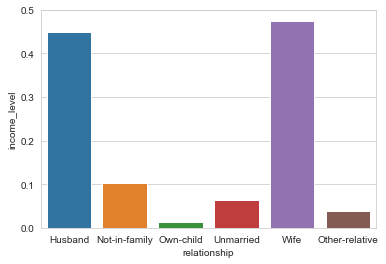

In [285]:
relation_perc = adult_df.groupby(["relationship"], as_index=False)["income_level"].mean()
sns.barplot(x="relationship", y="income_level", data=relation_perc, order=list(relation_cnt.index))                                                                          

## race: categorical

In [280]:
adult_df["race"] = adult_df.race.str.strip()
race_cnt = adult_df.race.value_counts()
print(race_cnt)

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


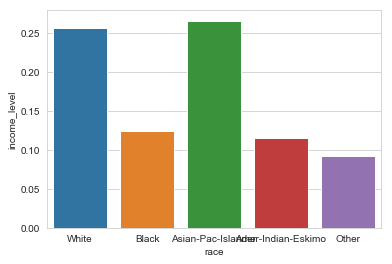

In [283]:
race_perc = adult_df.groupby(["race"], as_index=False)["income_level"].mean()
sns.barplot(x="race", y="income_level", data=race_perc, order=list(race_cnt.index))

## gender: categorical

In [243]:
adult_df["gender"] = adult_df.gender.str.strip()
print(adult_df.gender.value_counts())

Male      21790
Female    10771
Name: gender, dtype: int64


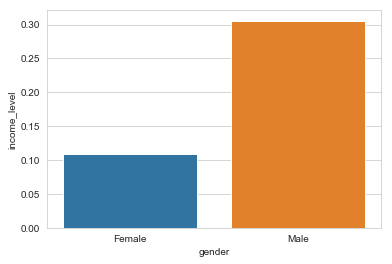

In [259]:
gender_perc = adult_df.groupby(["gender"], as_index=False)["income_level"].mean()
sns.barplot(x="gender", y="income_level", data=gender_perc)

## capital_gain: numerical

In [318]:
print(adult_df.capital_gain.describe())
print()
adult_df.groupby(["income_level"], as_index=False)["capital_gain"].mean()

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64



,income_level,capital_gain
0,0,148.752468
1,1,4006.142456


/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


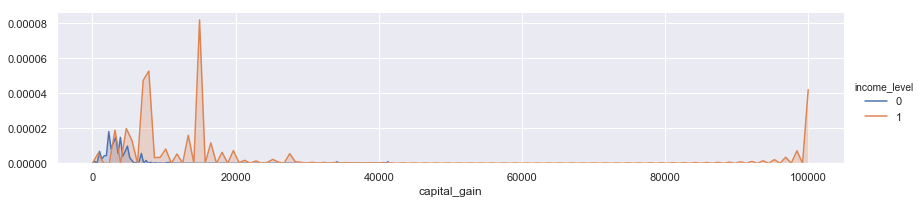

In [334]:
sns.FacetGrid(adult_df, hue="income_level", aspect=4)\
   .map(sns.kdeplot, 'capital_gain', shade= True)\
   .add_legend()

## capital_loss: numerical

In [319]:
print(adult_df.capital_loss.describe())
print()
adult_df.groupby(["income_level"], as_index=False)["capital_loss"].mean()

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64



,income_level,capital_loss
0,0,53.142921
1,1,195.001530


/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


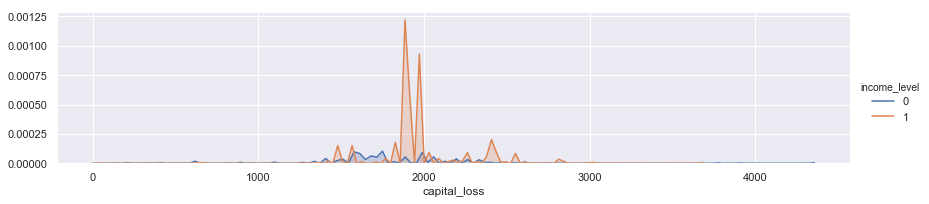

In [335]:
sns.FacetGrid(adult_df, hue="income_level", aspect=4)\
   .map(sns.kdeplot, 'capital_loss', shade= True)\
   .add_legend()

## hours_per_week: numerical

In [321]:
print(adult_df.hours_per_week.describe())
print()
adult_df.groupby(["hours_per_week"], as_index=False)["income_level"].mean()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64



,hours_per_week,income_level
0,1,0.100000
1,2,0.250000
2,3,0.025641
3,4,0.055556
4,5,0.116667
5,6,0.125000
6,7,0.153846
7,8,0.075862
8,9,0.055556
9,10,0.071942


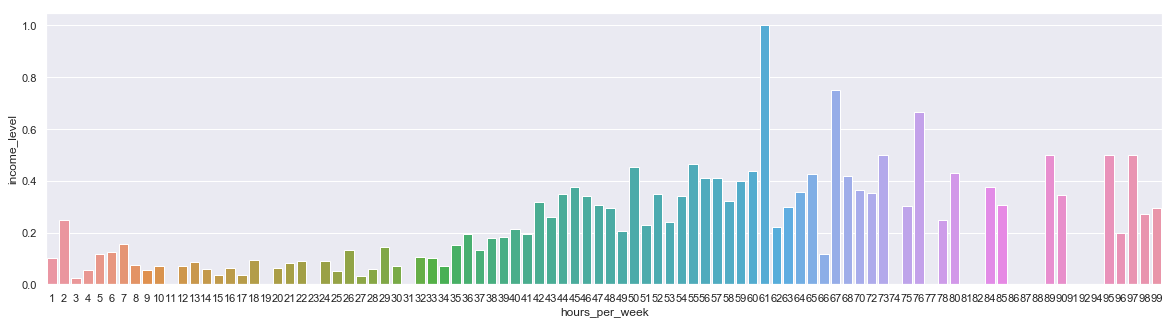

In [333]:
hour_perc = adult_df.groupby(["hours_per_week"], as_index=False)["income_level"].mean()
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(x="hours_per_week", y="income_level", data=hour_perc)

## country: categorical

In [142]:
adult_df["country"] = adult_df.country.str.strip()
print("{} coutries in the dataset".format(adult_df.country.nunique()))
print()
print("Top 10 countries in terms of record count")
print(adult_df.country.value_counts().head(10))
print()
print("US account for {:.2f}%".format(len(adult_df.loc[adult_df.country=="United-States"])/len(adult_df)))

42 coutries in the dataset

Top 10 countries in terms of record count
United-States    29170
Mexico             643
?                  583
Philippines        198
Germany            137
Canada             121
Puerto-Rico        114
El-Salvador        106
India              100
Cuba                95
Name: country, dtype: int64

US account for 0.90%


In [307]:
country_perc = adult_df.groupby(["country"], as_index=False)["income_level"].mean()
country_perc.sort_values("income_level", ascending=False).head(10)

,country,income_level
20,Iran,0.418605
10,France,0.413793
19,India,0.400000
36,Taiwan,0.392157
24,Japan,0.387097
41,Yugoslavia,0.375000
1,Cambodia,0.368421
22,Italy,0.342466
9,England,0.333333
2,Canada,0.322314


# Data Transformation: one-hot encoding

In [219]:
# don't consider education
keep_col = ['age','workclass','fnlwgt','edu_code','marital_status','occupation',
            'relationship','race','sex','capital_gain','capital_loss','hours_per_week','country']

X = pd.get_dummies(adult_df[keep_col])
y = adult_df.income_level.values
print(adult_df.shape, X.shape, y.shape)

(32561, 18) (32561, 92) (32561,)


# Machine Learning

In [220]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

In [221]:
# Train a XGBoost classifier
start_time = time.time()
print("Train model")

params = {'colsample_bylevel': 1.0,
          'colsample_bytree': 0.9,
          'gamma' : 1.0,
          'eta' : 0.05,
          'max_depth' : 16,
          'min_child_weight' : 0.5,
          'alpha': 30.0,
          'lambda': 10.0,
          'subsample': 0.9,
          'objective' : 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 2019}

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(xgb_train, 'train'), (xgb_test, 'eval')]
 
start_time = time.time()
xgb_clf = xgb.train(params, 
                    xgb_train, 
                    10000, 
                    watchlist, 
                    early_stopping_rounds=50, 
                    verbose_eval=10)

print('Execution time: {:0.2f}m'.format((time.time()-start_time)/60))
# [1024]	train-logloss:0.278169	eval-logloss:0.292103

Train model
[0]	train-logloss:0.66589	eval-logloss:0.665955
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.496735	eval-logloss:0.498844
[20]	train-logloss:0.410358	eval-logloss:0.414314
[30]	train-logloss:0.363933	eval-logloss:0.369062
[40]	train-logloss:0.337041	eval-logloss:0.342895
[50]	train-logloss:0.32025	eval-logloss:0.326949
[60]	train-logloss:0.309934	eval-logloss:0.317575
[70]	train-logloss:0.302994	eval-logloss:0.311296
[80]	train-logloss:0.298017	eval-logloss:0.306914
[90]	train-logloss:0.294502	eval-logloss:0.303969
[100]	train-logloss:0.292027	eval-logloss:0.301794
[110]	train-logloss:0.290146	eval-logloss:0.300221
[120]	train-logloss:0.288513	eval-logloss:0.298902
[130]	train-logloss:0.287346	eval-logloss:0.298013
[140]	train-logloss:0.286317	eval-logloss:0.297311
[150]	train-logloss:0.285568	eval-logloss:0.296798
[160]	train-logloss:0.284939	eval-lo

## Performance evaluation

In [224]:
def plot_roc(y_test, yp_test):
    fpr, tpr, thresholds = roc_curve(y_test, yp_test)
    roc_auc = auc(fpr, tpr)

    # Plot ROC, order prob by descending order
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.4f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Accuracy: 0.8680
ROC AUC: 0.9191


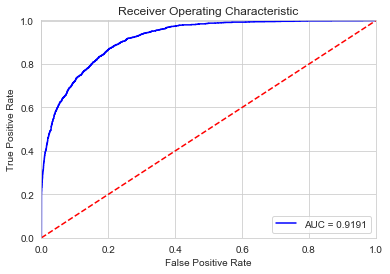

In [225]:
y_test_prob = xgb_clf.predict(xgb_test, ntree_limit=xgb_clf.best_ntree_limit)
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_test_pred)))
print('ROC AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_prob)))
plot_roc(y_test, y_test_prob)
# Accuracy: 0.8680

# Unsupervised Learning

In [179]:
X2 = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=2019)  
kmeans.fit(X2)  
print(kmeans.labels_)  
adult_df["kmeans_grp"] = kmeans.labels_

[0 1 0 ... 0 0 0]


In [181]:
print('Accuracy: {:.4f}'.format(accuracy_score(adult_df.income_level, adult_df.kmeans_grp)))

Accuracy: 0.7164
